### Beginning analysis of Beta maritima data from chromosome 1

In [1]:
import numpy as np
import zarr
import numcodecs
import allel; print('scikit-allel', allel.__version__)

/mnt/Data/Programs/Anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scikit-allel 1.1.10


I am beginning this analysis with a conversion of the vcf data to a compressed zarr directory. This type of file can always have new chromosomal data added to it and it should be smaller overall than the original vcf file. Additionally, ```scikit-allel``` reads this data in and parses all the data into a nice directory tree from which the data can be more easily accessed and analyzed.

In [2]:
datadir = "/home/jamc/Data/GitHub/BetaAnalysis/data/"
vcffile = datadir + "Bmar_proper_rmdup_ready_sorted_Bvchr1_combined_genotyped.vcf"
zarr_group = datadir + "beta_analysis_v1p0.zr"

In [3]:
# allel.vcf_to_zarr(
#     vcffile, zarr_group, group="Bvchr1",
#     fields='*', overwrite=True,
#     compressor=numcodecs.Blosc(
#         cname='zstd', clevel=1, shuffle=False
#     )
# )

In [4]:
# load variant call directory
callset = zarr.open_group(zarr_group, mode='r')
# show directory structure
callset.tree(expand=True)

/
 └── Bvchr1
     ├── calldata
     │   ├── AD (5018837, 170, 4) int16
     │   ├── DP (5018837, 170) int16
     │   ├── GQ (5018837, 170) int8
     │   ├── GT (5018837, 170, 2) int8
     │   ├── MBQ (5018837, 170, 3) float32
     │   ├── MFRL (5018837, 170, 4) float32
     │   ├── MIN_DP (5018837, 170) int32
     │   ├── MMQ (5018837, 170, 3) float32
     │   ├── MPOS (5018837, 170, 3) float32
     │   ├── PGT (5018837, 170) object
     │   ├── PID (5018837, 170) object
     │   ├── PL (5018837, 170, 3) int32
     │   ├── RGQ (5018837, 170) int32
     │   └── SB (5018837, 170, 4) int32
     ├── samples (170,) object
     └── variants
         ├── AC (5018837, 3) int32
         ├── AF (5018837, 3) float32
         ├── ALT (5018837, 3) object
         ├── AN (5018837,) int32
         ├── BaseQRankSum (5018837,) float32
         ├── CHROM (5018837,) object
         ├── ClippingRankSum (5018837,) float32
         ├── DP (5018837,) int32
         ├── DS (5018837,) bool
         ├── END (5018837,) int32
         ├── ExcessHet (5018837,) float32
         ├── FILTER_LowQual (5018837,) bool
         ├── FILTER_PASS (5018837,) bool
         ├── FS (5018837,) float32
         ├── ID (5018837,) object
         ├── InbreedingCoeff (5018837,) float32
         ├── MLEAC (5018837, 3) int32
         ├── MLEAF (5018837, 3) float32
         ├── MQ (5018837,) float32
         ├── MQRankSum (5018837,) float32
         ├── POS (5018837,) int32
         ├── QD (5018837,) float32
         ├── QUAL (5018837,) float32
         ├── RAW_MQ (5018837,) float32
         ├── REF (5018837,) object
         ├── ReadPosRankSum (5018837,) float32
         ├── SOR (5018837,) float32
         ├── is_snp (5018837,) bool
         ├── numalt (5018837,) int32
         └── svlen (5018837, 3) int32

In [5]:
ninds = len(callset['Bvchr1/samples'][:])
print("Number of individuals to be analyzed: %s" % ninds)

Number of individuals to be analyzed: 170


In [14]:
Bvchr1_SOR =  callset['Bvchr1/variants/SOR'][:] < 3
Bvchr1_SNP =  callset['Bvchr1/variants/is_snp'][:]
Bvchr1_QD =   callset['Bvchr1/variants/QD'][:] > 10
Bvchr1_MQ =   callset['Bvchr1/variants/MQ'][:] > 25
Bvchr1_DPU =  callset['Bvchr1/variants/DP'][:] < 1700
Bvchr1_DPL =  callset['Bvchr1/variants/DP'][:] > 340
Bvchr1_MQRS = callset['Bvchr1/variants/MQRankSum'][:] > -12.5
Bvchr1_BQRS = callset['Bvchr1/variants/BaseQRankSum'][:] > -12.5
Bvchr1_RPRS = callset['Bvchr1/variants/ReadPosRankSum'][:] > -8.0
Bvchr1_ALT = []

for alt in callset['Bvchr1/variants/ALT'][:]:
    if len(set(alt)) == 2:
        Bvchr1_ALT.append(True)
    else:
        Bvchr1_ALT.append(False)


filters = np.array((
    Bvchr1_SOR, Bvchr1_SNP, Bvchr1_QD, Bvchr1_MQ, Bvchr1_DPU,
    Bvchr1_DPL, Bvchr1_MQRS, Bvchr1_BQRS, Bvchr1_RPRS, Bvchr1_ALT
))

# Bvchr1_filter = np.logical_and.reduce(
#     (
#         Bvchr1_SOR, Bvchr1_SNP, Bvchr1_QD, Bvchr1_MQ, Bvchr1_DPU,
#         Bvchr1_DPL, Bvchr1_MQRS, Bvchr1_BQRS, Bvchr1_RPRS
#     )
# )

Bvchr1_filter = np.all(filters, axis=0)

good_variants = Bvchr1_filter.sum()
print("Number of filter passing variants: %s" % good_variants)

/mnt/Data/Programs/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/Data/Programs/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/mnt/Data/Programs/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/mnt/Data/Programs/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/mnt/Data/Programs/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


Number of filter passing variants: 1966507


In [7]:
Bvchr1_SNP, Bvchr1_filter_test[5]

NameError: name 'Bvchr1_filter_test' is not defined

In [8]:
Bvchr1_ref   = callset['Bvchr1/variants/REF'][:]
Bvchr1_alt   = callset['Bvchr1/variants/ALT'][:]
# Apply filter to chromosome and position from the reference genome
Bvchr1_chromosome = callset['Bvchr1/variants/CHROM'][:]
Bvchr1_position   = callset['Bvchr1/variants/POS'][:]

first_scaffold = Bvchr1_chromosome == "Bvchr1.sca001"
Bvchr1_sca001_filter = np.logical_and(first_scaffold, Bvchr1_filter)
print(Bvchr1_sca001_filter)

Bvchr1_filtered_chromosome = Bvchr1_chromosome.compress(Bvchr1_sca001_filter, axis=0)
Bvchr1_filtered_position   = Bvchr1_position.compress(  Bvchr1_sca001_filter, axis=0)
Bvchr1_filtered_ref   = Bvchr1_ref.compress(  Bvchr1_sca001_filter, axis=0)
Bvchr1_filtered_alt   = Bvchr1_alt.compress(  Bvchr1_sca001_filter, axis=0)

# Now we check if the CHROM annotation is equal to the scaffold name
# Bvchr1_bvchr_sca001 = np.equal(
#     Bvchr1_filtered_chromosome[:], ["Bvchr1.sca001"]
# )

# Bvchr1_sca001_filter = np.logical_and(Bvchr1_bvchr_sca001, Bvchr1_filter)

# Bvchr1_filtered_ref   = Bvchr1_ref.compress(  Bvchr1_sca001_filter, axis=0)
# Bvchr1_filtered_alt   = Bvchr1_alt.compress(  Bvchr1_sca001_filter, axis=0)

# Kind of inefficient, but can get the last index by cumulative sum
# This will be the last time that CHROM == "Scaffold-name"
Bvchr1_sca001_pos = np.cumsum(Bvchr1_sca001_filter)
Bvchr1_positions = allel.SortedIndex(
    Bvchr1_filtered_position[0:Bvchr1_sca001_pos[-1]]
)
Bvchr1_positions

[False False False ... False False False]


0,1,2,3,4,...,118804,118805,118806,118807,118808
8090,8301,8346,8402,8419,...,8252090,8252097,8252100,8252133,8255845


In [9]:
Bvchr1_filtered_ref, Bvchr1_filtered_alt

(array(['C', 'A', 'C', ..., 'C', 'A', 'G'], dtype=object),
 array([['T', '', ''],
        ['G', '', ''],
        ['G', '', ''],
        ...,
        ['T', '', ''],
        ['T', '', ''],
        ['A', '', '']], dtype=object))

In [10]:
# Plotting function taken from the following address:
# http://alimanfoo.github.io/2017/06/14/read-vcf.html
def plot_windowed_variant_density(pos, window_size, title=None):
    
    # setup windows
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
    return y.mean()

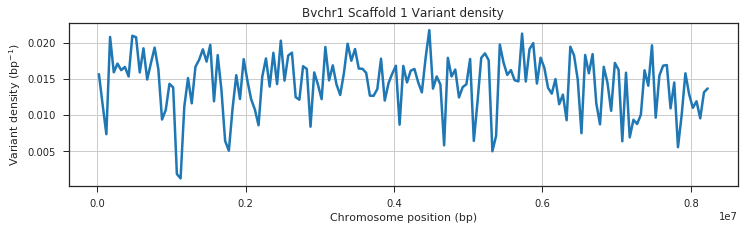

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks", {"axes.grid": True})
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

Bvchr1_Scaffold001_mean_vd = plot_windowed_variant_density(
    Bvchr1_positions, window_size=50000, title='Bvchr1 Scaffold 1 Variant density'
)

In [12]:
print(1/Bvchr1_Scaffold001_mean_vd)

69.4537984913793


In [21]:
PL = allel.GenotypeDaskArray(callset['Bvchr1/calldata/PL'])

In [22]:
PL

<GenotypeDaskArray shape=(5018837, 170, 3) dtype=int32>

In [23]:
Good_SNPs = PL.compress(Bvchr1_sca001_filter, axis=0)
Good_SNPs

<GenotypeDaskArray shape=(386231, 170, 3) dtype=int32>

In [ ]:
Good_SNPs[0,:,0]

In [24]:
import dask.array
non_phred = np.power(10, -Good_SNPs/10)
non_phred_sum = non_phred.sum(axis=2)
# repeat the summed value 3 times
x=dask.array.repeat(non_phred_sum, 3, axis=1)
# reshape the sums to fit the dimension of non_phred tensor
y=dask.array.reshape(x, (non_phred.shape[0], non_phred.shape[1], 3))
non_phred_sum = y

In [25]:
non_phred_normalized = np.divide(non_phred, non_phred_sum)
# non_phred_normalized[0,:,:]
# test_file = open("/home/jamc/test.txt", "w")
# test_file.write(str(non_phred_normalized[0,:,:].flatten()))
# test_file.close()

In [26]:
tester = dask.array.reshape(non_phred_normalized, (non_phred_normalized.shape[0], non_phred_normalized.shape[1]*3))
# dask.array.to_npy_stack(datadir + "npy_stacks", tester)
# np.savetxt(datadir + "test_numpy.txt.gz", tester, fmt='%10.6f', delimiter='\t', newline='\n', header=header)

In [17]:
allele_dict = {"A": '0', "C":'1', "G":'2', "T":'3'}
header = ["marker", "allele1", "allele2"]
header = []
for x in range(170):
    header += ['Ind%s' % x]*3
header = "\t".join(header)
# header
    

In [ ]:
concat = dask.array.hstack((np.array([Bvchr1_filtered_position], dtype=np.int32).T, tester))
Bvchr1_filtered_position.T.shape, tester.shape

In [ ]:
# test = [-int(x)/10 for x in Good_SNPs_Bvchr1_Sca001[0][0]]
test = np.array([np.power(10, -int(x)/10) for x in Good_SNPs_Bvchr1_Sca001[0][0]])
list(np.round(np.divide(test,test.sum()), 6))
# np.power(10, test).sum()

In [ ]:
Bvchr1_filtered_ref[0]

In [ ]:
np.array([[1],[2],[3]]).shape

In [ ]:
np.array([Bvchr1_filtered_position]).T.shape

In [ ]:
concat

In [29]:
# float(concat[0,0])
markers = []
for x,y in zip(Bvchr1_filtered_chromosome, Bvchr1_filtered_position):
    markers.append("%s_%s" % (x,y))

In [21]:
concat = dask.array.hstack((np.array([alt_alleles], dtype=np.int8).T, tester))
concat = dask.array.hstack((np.array([ref_alleles], dtype=np.int8).T, concat))
# concat = dask.array.hstack((np.array([Bvchr1_filtered_position], dtype=np.int32).T, concat))
concat = dask.array.hstack((np.array([markers], dtype=str).T, concat))


In [ ]:
concat[0,0]

In [ ]:
concat[0,0]

In [31]:
alt_alleles = []
allele_dict = {"A": '0', "C":'1', "G":'2', "T":'3'}

for val in Bvchr1_filtered_alt:
    alt_alleles.append(allele_dict[val[0]])

ref_alleles = []

for val in Bvchr1_filtered_ref:
    ref_alleles.append(allele_dict[val])

In [ ]:
np.array(alt_alleles).shape

In [ ]:
np.array([Bvchr1_filtered_position], dtype=np.int32)

In [27]:
# header = ["marker", "allele1", "allele2"]
header = []
for x in range(170):
    header += ['Ind%s' % x]*3
header = "\t".join(header)
header

'Ind0\tInd0\tInd0\tInd1\tInd1\tInd1\tInd2\tInd2\tInd2\tInd3\tInd3\tInd3\tInd4\tInd4\tInd4\tInd5\tInd5\tInd5\tInd6\tInd6\tInd6\tInd7\tInd7\tInd7\tInd8\tInd8\tInd8\tInd9\tInd9\tInd9\tInd10\tInd10\tInd10\tInd11\tInd11\tInd11\tInd12\tInd12\tInd12\tInd13\tInd13\tInd13\tInd14\tInd14\tInd14\tInd15\tInd15\tInd15\tInd16\tInd16\tInd16\tInd17\tInd17\tInd17\tInd18\tInd18\tInd18\tInd19\tInd19\tInd19\tInd20\tInd20\tInd20\tInd21\tInd21\tInd21\tInd22\tInd22\tInd22\tInd23\tInd23\tInd23\tInd24\tInd24\tInd24\tInd25\tInd25\tInd25\tInd26\tInd26\tInd26\tInd27\tInd27\tInd27\tInd28\tInd28\tInd28\tInd29\tInd29\tInd29\tInd30\tInd30\tInd30\tInd31\tInd31\tInd31\tInd32\tInd32\tInd32\tInd33\tInd33\tInd33\tInd34\tInd34\tInd34\tInd35\tInd35\tInd35\tInd36\tInd36\tInd36\tInd37\tInd37\tInd37\tInd38\tInd38\tInd38\tInd39\tInd39\tInd39\tInd40\tInd40\tInd40\tInd41\tInd41\tInd41\tInd42\tInd42\tInd42\tInd43\tInd43\tInd43\tInd44\tInd44\tInd44\tInd45\tInd45\tInd45\tInd46\tInd46\tInd46\tInd47\tInd47\tInd47\tInd48\tInd48\tInd48\t

In [ ]:
np.savetxt(datadir + "test_again_numpy.txt.gz", concat, fmt='%10.6f', delimiter='\t', newline='\n', header=header)

In [20]:
dask.array.to_npy_stack(datadir + "npy_stacks", concat)

KeyboardInterrupt: 

In [28]:
np.savetxt(datadir + "test_numpy.txt.gz", tester, fmt='%10.6f', delimiter='\t', newline='\n', header=header, comments='')

In [33]:
new_cols = open(datadir + "new_cols.txt", "w")
head = "markers\tallele1\tallele2"
print(head, file=new_cols)
for val in zip(markers, ref_alleles, alt_alleles):
    line = "\t".join(val)
    print(line, file=new_cols)
print("\n", file=new_cols)